In [1]:
import os
import re
import glob
import os.path as osp
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from skimage import io as sk_io
from skimage.transform import resize
from skimage.color import gray2rgb, rgb2gray
from skimage.exposure import rescale_intensity
from cvutils.rectlabel import io as rectlabel_io
from cvutils.mrcnn.session import init_keras_session
from cvutils import visualize
from celldom.dataset import utils as dataset_utils
from celldom import seed

import celldom
import keras
from keras.preprocessing import image
import wandb
from wandb.keras import WandbCallback

init_keras_session()

DATA_DIR_VALIDATED_EXTRACT = osp.join(celldom.get_dataset_dir(), 'training', 'digit', 'r0.6', 'validated', 'single')
DATA_DIR_MANUAL_ANNOTATION = osp.join(celldom.get_dataset_dir(), 'training', 'digit', 'r0.6', 'manual', 'single')
DATA_DIR_MANUAL_PARTITIONS = ['pt1', 'pt2', 'pt3', 'pt4']
#MODEL_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.6', 'digit_model')
MODEL_DIR = osp.join(os.environ['CELLDOM_DATA_DIR'], 'model', 'r0.7', 'digit_model')

MODEL_PATH_HEAD = osp.join(MODEL_DIR, 'single_digit_model_headonly.h5')
MODEL_PATH = osp.join(MODEL_DIR, 'single_digit_model.h5')

MODEL_DIR, DATA_DIR_VALIDATED_EXTRACT, DATA_DIR_MANUAL_ANNOTATION

Using TensorFlow backend.


('/lab/data/celldom/model/r0.7/digit_model',
 '/lab/data/celldom/dataset/training/digit/r0.6/validated/single',
 '/lab/data/celldom/dataset/training/digit/r0.6/manual/single')

In [2]:
!ls $DATA_DIR_VALIDATED_EXTRACT | head -n 1

BF_ST_000_APT_000Day0-APT-0-0.jpeg
ls: write error: Broken pipe


In [3]:
def get_actual_digit(file):
    return osp.basename(file).replace('.jpeg', '').split('-')[-1]

def load_extracted_images():
    res = []
    for f in glob.glob(osp.join(DATA_DIR_VALIDATED_EXTRACT, '*.jpeg')):
        digit = get_actual_digit(f)
        img = sk_io.imread(osp.join(DATA_DIR_VALIDATED_EXTRACT, f))
        res.append((int(digit), img, f))
    res = pd.DataFrame(res, columns=['digit', 'img', 'file'])
    return res

def load_annotated_images():
    res = []
    for pt in DATA_DIR_MANUAL_PARTITIONS:
        df = dataset_utils.get_data_files(osp.join(DATA_DIR_MANUAL_ANNOTATION, pt))
        for i, r in tqdm.tqdm(df.iterrows(), desc='partition=' + pt):
            img_path, annot_path = r['image_path'], r['annot_path']
            if r['annot_exists']:
                try:
                    shape, annotations = rectlabel_io.load_annotations(annot_path, assert_masks=False)
                    assert len(annotations) == 1, 'Found multiple annotations in {}'.format(annot_path)
                    digit = annotations[0].object_type
                    if digit == 'NA':
                        continue
                    # Read RGB 8-bit image
                    img = sk_io.imread(img_path)

                    # Extract grayscale based on assumption of channel equality
                    assert img.ndim == 3 and img.shape[-1] == 3
                    assert np.allclose(img[..., 0], img[..., 1])
                    assert np.allclose(img[..., 0], img[..., 2])
                    img = img[..., 0]
                    digit = int(digit)
                except:
                    print('Failure occurred for annotation file {}'.format(annot_path))
                    raise
                res.append((digit, img, img_path, pt))
    res = pd.DataFrame(res, columns=['digit', 'img', 'file', 'partition'])
    return res


In [4]:
%%time
df = pd.concat([
    load_extracted_images().assign(source='extract'),
    load_annotated_images().assign(source='annotated')
])

partition=pt1: 2492it [00:02, 959.60it/s]
partition=pt2: 456it [00:00, 1061.00it/s]
partition=pt3: 2136it [00:02, 1032.98it/s]
partition=pt4: 1308it [00:01, 1014.82it/s]

CPU times: user 5.78 s, sys: 1.21 s, total: 6.99 s
Wall time: 8.23 s


In [5]:
# r0.2 num files = 2372, r0.6 = 8067, r0.7 = 9375
len(df)

9375

In [6]:
df['source'].value_counts()

annotated    6157
extract      3218
Name: source, dtype: int64

In [7]:
df.groupby(['source', 'partition']).size()

source     partition
annotated  pt1          2415
           pt2           440
           pt3          1994
           pt4          1308
dtype: int64

In [8]:
df['digit'].value_counts()

0    2773
1    2673
3     810
2     770
4     605
5     359
9     351
7     348
6     345
8     341
Name: digit, dtype: int64

In [9]:
df.groupby(['source', 'digit']).size().unstack()

digit,0,1,2,3,4,5,6,7,8,9
source,,,,,,,,,,
annotated,1285,2147,585,636,425,204,212,225,209,229
extract,1488,526,185,174,180,155,133,123,132,122


In [10]:
dtypes = df['img'].apply(lambda v: v.dtype)
assert np.all(dtypes == np.uint8)
dtypes.value_counts()

uint8    9375
Name: img, dtype: int64

In [11]:
pd.DataFrame([r['img'].shape for _, r in df.iterrows()]).describe()

,0,1
count,9375.000000,9375.000000
mean,42.103787,29.493867
std,10.503142,7.688318
min,22.000000,19.000000
25%,31.000000,22.000000
50%,42.000000,27.000000
75%,53.000000,36.000000
max,58.000000,46.000000


In [12]:
from sklearn.model_selection import train_test_split
idx = np.arange(len(df))

# Vary test_size (starting large) to get a sense of accuracy with a bigger sample and then decrease for final model
idx_train, idx_test = train_test_split(idx, test_size=.2, random_state=seed, stratify=df['digit'])
df_train, df_test = df.iloc[idx_train], df.iloc[idx_test]

len(df_train), len(df_test)

(7500, 1875)

In [13]:
pd.concat([df_train['digit'].value_counts(normalize=True), df_test['digit'].value_counts(normalize=True)], axis=1)

,digit,digit
0,0.295867,0.295467
1,0.285067,0.285333
3,0.086400,0.086400
2,0.082133,0.082133
4,0.064533,0.064533
5,0.038267,0.038400
9,0.037467,0.037333
7,0.037067,0.037333
6,0.036800,0.036800
8,0.036400,0.036267


## Training

In [14]:
%run utils.py

In [15]:
target_shape = (32, 32)

In [17]:
from imgaug import augmenters as iaa
from skimage import img_as_ubyte, img_as_float32

sometimes = lambda aug: iaa.Sometimes(.2, aug)
seq = iaa.Sequential([
    # Simulate out-of-focus
    sometimes(iaa.GaussianBlur(sigma=.3)),
    
    # Randomly alter scaling and simulate zooming
    sometimes(iaa.OneOf([
        iaa.CropAndPad(px=(0, 12)),
        iaa.Crop(px=(0, 12))
    ])),
    
    # Rotate up to 3 degrees and randomly scale
    sometimes(iaa.Affine(
        rotate=3., 
        scale={"x": (.8, 1.4), "y": (.8, 1.4)}, 
        translate_px=(0, 5),
        mode='constant'
    )),    
    
    # Randomly alter distribution
    sometimes(iaa.OneOf([
        iaa.Multiply((.8, 1.4)), 
        iaa.Add((-25, 25)),
        iaa.ContrastNormalization((0.8, 1.2))
    ]))
], random_order=True)

def augment(img):
    # img should be provided as float in [0, 1]
    assert img.min() >= 0 and img.max() <= 1.
    img = rescale_intensity(img, out_range=np.uint8).astype(np.uint8)
    res = img_as_float32(seq.augment_image(img))
    #print(res.shape, res.dtype, res.min(), res.max())
    return res

In [18]:
def prep_image(img):
    # Note that gray2rgb will take care of converting from uint8 to float in 0-1
    assert img.dtype == np.uint8
    
    # Convert to 2D with target height/width
    img = gray2rgb(resize(img, target_shape, mode='constant', anti_aliasing=True)).astype(np.float32)
    
    # Rescale by min/max
    img = rescale_intensity(img, out_range=(0, 1))
    
    assert np.all(img <= 1.) and np.all(img >= 0.)
    return img

train_x = np.stack([prep_image(v) for v in df_train['img']], 0)
train_y = keras.utils.to_categorical(df_train['digit'].values, 10)

test_x = np.stack([prep_image(v) for v in df_test['img']], 0)
test_y = keras.utils.to_categorical(df_test['digit'].values, 10)

train_generator = image.ImageDataGenerator(preprocessing_function=augment)
train_batches = train_generator.flow(train_x, y=train_y, seed=seed)

test_generator = image.ImageDataGenerator()
test_batches = test_generator.flow(test_x, y=test_y, seed=seed)

train_x.dtype, train_x.shape, test_x.shape

(dtype('float32'), (7500, 32, 32, 3), (1875, 32, 32, 3))

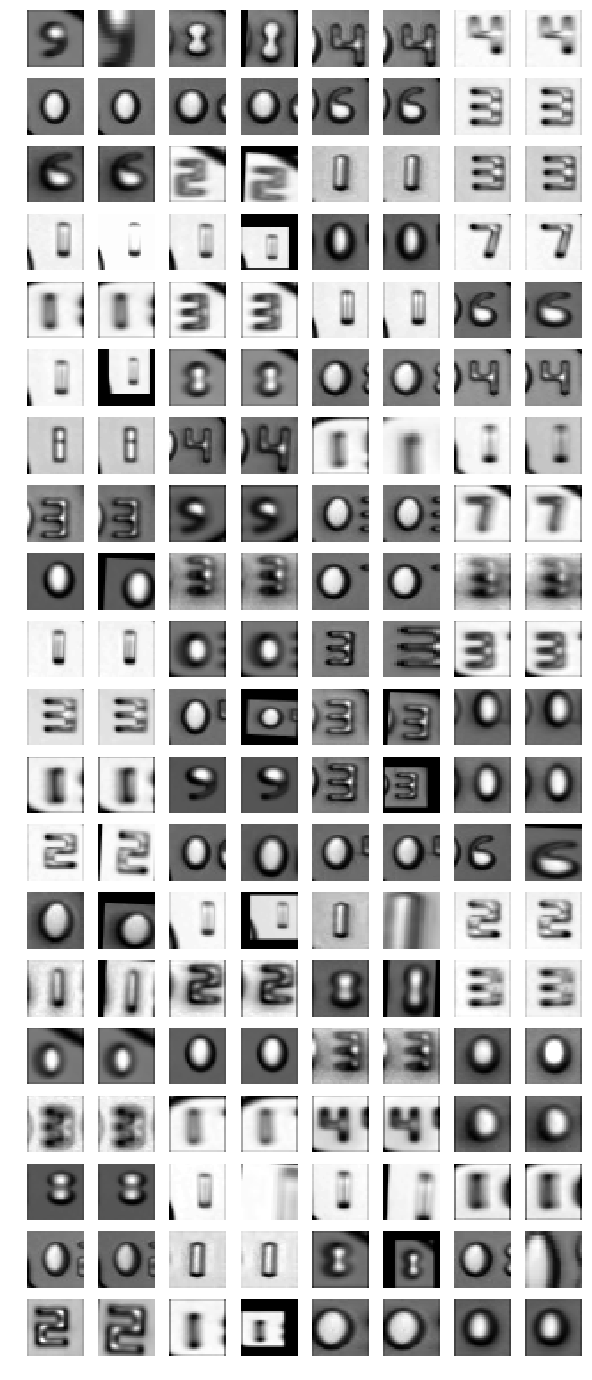

In [19]:
# Visualize augmentations
aug_imgs = []
for img in df_train['img'].sample(n=80):
    aug_imgs.append(prep_image(img))
    aug_imgs.append(augment(prep_image(img)))
visualize.display_images(aug_imgs, cols=8, size=10)

In [20]:
from scipy.stats import describe
describe(aug_imgs[0].ravel())

DescribeResult(nobs=3072, minmax=(0.0, 1.0), mean=0.40714803, variance=0.020912908, skewness=-0.2574825882911682, kurtosis=2.4543907329458623)

### Initialize Modeling

In [21]:
MODEL_DIR

'/lab/data/celldom/model/r0.7/digit_model'

In [22]:
!ls $MODEL_DIR

single_digit_model.h5  single_digit_model_headonly.h5


In [23]:
# Clear everything currently in the modeling directory
!rm -rf $MODEL_DIR/*

In [24]:
wandb.init()

W&B Run: https://app.wandb.ai/hammerlab/celldom/runs/c8ywa03w
Wrap your training loop with `with wandb.monitor():` to display live results.


W&B Run https://app.wandb.ai/hammerlab/celldom/runs/c8ywa03w

### Run Training

In [25]:
MODEL_DIR

'/lab/data/celldom/model/r0.7/digit_model'

In [26]:
if not osp.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [27]:
!ls $MODEL_DIR

In [28]:
model = get_digit_model(input_shape=target_shape + (3,), mode='head')
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(lr=.001),
    metrics=['accuracy']
)

# Initialize from pre-trained model
model.load_weights('/lab/repos/svhn/weights.hdf5')

In [29]:
save_model = keras.callbacks.ModelCheckpoint(MODEL_PATH_HEAD, monitor='val_loss', mode='min', verbose=0,
                                             save_best_only=True, save_weights_only=False, period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
learning_rate = keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss', mode='min', verbose=1)
callbacks = [save_model, early_stopping, learning_rate]

# tensorboard = keras.callbacks.TensorBoard(log_dir=MODEL_DIR)
# callbacks = [save_model, early_stopping, learning_rate, tensorboard]

with wandb.monitor(display=False):
    model.fit_generator(
        train_batches, 
        epochs=250,
        callbacks=callbacks + [WandbCallback(save_model=False)],
        validation_data=test_batches
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/c8ywa03w


Epoch 1/250
235/235 [==============================] - 11s 48ms/step - loss: 0.5663 - acc: 0.8475 - val_loss: 0.0773 - val_acc: 0.9776
Epoch 2/250
235/235 [==============================] - 10s 42ms/step - loss: 0.2982 - acc: 0.9145 - val_loss: 0.0458 - val_acc: 0.9824
Epoch 3/250
235/235 [==============================] - 10s 44ms/step - loss: 0.2578 - acc: 0.9325 - val_loss: 0.0311 - val_acc: 0.9893
Epoch 4/250
235/235 [==============================] - 10s 43ms/step - loss: 0.2344 - acc: 0.9364 - val_loss: 0.0260 - val_acc: 0.9936
Epoch 5/250
235/235 [==============================] - 10s 42ms/step - loss: 0.1992 - acc: 0.9465 - val_loss: 0.0219 - val_acc: 0.9952
Epoch 6/250
235/235 [==============================] - 10s 42ms/step - loss: 0.1910 - acc: 0.9501 - val_loss: 0.0189 - val_acc: 0.9941
Epoch 7/250
235/235 [==============================] - 11s 45ms/step - loss: 0.1745 - acc: 0.9560 - val_loss: 0.0173 - val_acc: 0.9947
Epoch 8/250
235/235 [==============================] - 

### Fine-Tuning

In [30]:
#model = get_digit_model(input_shape=target_shape + (3,), mode='tune')
model = get_digit_model(input_shape=target_shape + (3,), mode='all')
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.RMSprop(lr=.0001),
    metrics=['accuracy']
)

# Initialize from pre-trained model
model.load_weights(MODEL_PATH_HEAD)

In [31]:
save_model = keras.callbacks.ModelCheckpoint(MODEL_PATH, monitor='val_loss', mode='min', verbose=0,
                                             save_best_only=True, save_weights_only=False, period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min')
learning_rate = keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss', mode='min', verbose=1)
callbacks = [save_model, early_stopping, learning_rate]

# tensorboard = keras.callbacks.TensorBoard(log_dir=MODEL_DIR)
# callbacks = [save_model, early_stopping, learning_rate, tensorboard]

with wandb.monitor(display=False):
    model.fit_generator(
        train_batches, 
        epochs=250,
        callbacks=callbacks + [WandbCallback(save_model=False)],
        validation_data=test_batches
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/c8ywa03w


Epoch 1/250
235/235 [==============================] - 11s 46ms/step - loss: 0.1367 - acc: 0.9661 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 2/250
235/235 [==============================] - 10s 41ms/step - loss: 0.0973 - acc: 0.9730 - val_loss: 8.5180e-04 - val_acc: 1.0000
Epoch 3/250
235/235 [==============================] - 11s 45ms/step - loss: 0.1033 - acc: 0.9738 - val_loss: 7.9742e-04 - val_acc: 1.0000
Epoch 4/250
235/235 [==============================] - 10s 42ms/step - loss: 0.0935 - acc: 0.9730 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 5/250
235/235 [==============================] - 10s 42ms/step - loss: 0.1235 - acc: 0.9688 - val_loss: 0.0014 - val_acc: 0.9989

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 6/250
235/235 [==============================] - 10s 42ms/step - loss: 0.0893 - acc: 0.9769 - val_loss: 0.0012 - val_acc: 0.9995
Epoch 7/250
235/235 [==============================] - 10s 42ms/step - loss: 0.0918 - acc: 0.9754 - v

## Inference 

In [34]:
model = keras.models.load_model(MODEL_PATH)

In [41]:
#inf_x, inf_y = test_x, test_y
inf_x, inf_y = train_x, train_y
inf_y = np.argmax(inf_y, axis=1)
inf_x.shape, inf_y.shape

((7500, 32, 32, 3), (7500,))

In [42]:
inf_y_pred = model.predict_classes(inf_x)
inf_y_pred.shape

(7500,)

In [43]:
# Overall accuracy
(inf_y_pred == inf_y).mean()

0.9998666666666667

In [44]:
pd.DataFrame(dict(pred=inf_y_pred, true=inf_y)).groupby(['pred', 'true']).size().unstack().fillna(0)\
    .style.background_gradient(high=.7)

true,0,1,2,3,4,5,6,7,8,9
pred,,,,,,,,,,
0,2219,0,0,0,0,0,0,0,0,0
1,0,2137,0,0,0,0,0,0,0,0
2,0,0,616,0,0,0,0,0,0,0
3,0,0,0,648,0,0,0,0,0,0
4,0,1,0,0,484,0,0,0,0,0
5,0,0,0,0,0,287,0,0,0,0
6,0,0,0,0,0,0,276,0,0,0
7,0,0,0,0,0,0,0,278,0,0
8,0,0,0,0,0,0,0,0,273,0


#### Show Misclassified Instances (if any)

In [45]:
misclassified = np.argwhere(inf_y_pred != inf_y).ravel()

In [46]:
len(misclassified)

1

In [47]:
misclassified

array([6988])

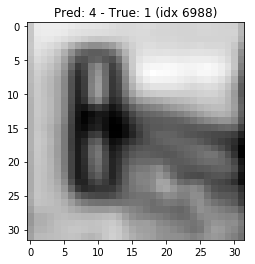

In [48]:
#n_samp = 10
#indexes = pd.Series(list(range(len(pred_y_class)))).sample(n_samp)

n_samp = len(misclassified)
indexes = misclassified

fig, ax = plt.subplots(n_samp, 1)
if n_samp == 1:
    ax = [ax]
fig.set_size_inches(4, n_samp * 4)
for i, idx in enumerate(indexes):
    ax[i].imshow(inf_x[idx])
    ax[i].set_title('Pred: {} - True: {} (idx {})'.format(inf_y_pred[idx], inf_y[idx], idx))

In [68]:
# Use the "idx" above to get the file the example came from
df.iloc[idx_train[5931]]['file']

'/lab/data/celldom/dataset/training/digit/r0.6/manual/single/pt3/chip_01-9afff6da4531832f02d8bd6b3e33a9d1-4-st-0-0.png'

In [49]:
MODEL_PATH

'/lab/data/celldom/model/r0.7/digit_model/single_digit_model.h5'

In [53]:
# Overwrite model in cache to avoid needing to redownload from google storage
!cp /lab/data/celldom/model/r0.6/digit_model/single_digit_model.h5 /lab/data/celldom/.celldom/cache/models/single_digit_model.h5

In [ ]:
# Upload to GS
# gsutil cp /data/disk2/celldom/model/r0.7/digit_model/single_digit_model.h5 gs://celldom/models/r0.7/single_digit_model.h5